# Sub-graphs



In [17]:
%%capture --no-stderr
%pip install -U  langgraph

In [18]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [19]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## Sub graphs


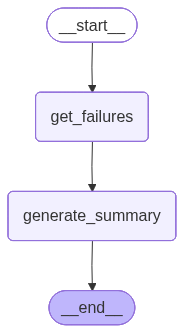

In [20]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

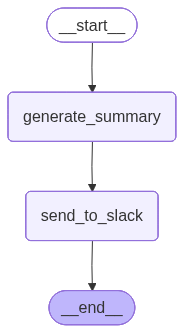

In [21]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding sub graphs to our parent graph


In [22]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[str], add] # This will be generated in BOTH sub-graphs
    final_report: str #combinine fa_summary and report

But, why does `cleaned_logs` have a reducer if it only goes *into* each sub-graph as an input? It is not modified.


This is because the output state of the subgraphs will contain **all keys**, even if they are unmodified. 

The sub-graphs are run in parallel.

Because the parallel sub-graphs return the same key, it needs to have a reducer like `operator.add` to combine the incoming values from each sub-graph.



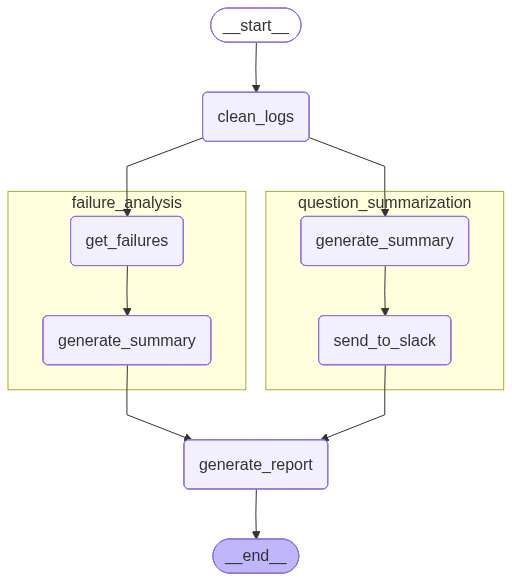

In [23]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[str], add] # This will be generated in BOTH sub-graphs
    final_report: str #combinine fa_summary and report

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

def generate_final_report(state: EntryGraphState):
    """
    Takes the failure summary and the question summary 
    and compiles a single final report.
    """
    print("FINAL REPORT")
    
    fa_summary = state.get("fa_summary", "No failures found.")
    qs_report = state.get("report", "No question summary report generated.")
    
    final_report = (
        f"Operations Report\n\n"
        f"  Failure Analysis  :\n{fa_summary}\n\n"
        f"  Question Summary  :\n{qs_report}\n"
    )
    
    return {"final_report": final_report}



entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
entry_builder.add_node("generate_report", generate_final_report)

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", "generate_report")
entry_builder.add_edge("question_summarization", "generate_report")
entry_builder.add_edge("generate_report", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [24]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

FINAL REPORT


{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 